# Course Work - Facial Expression Recoginnision

Module: Computer Vision - INM460

By: Asha Guruvayurappan

## **Multi-Layer Perceptron with HOG**

Implementing a series of image classification models using dataset from https://forms.gle/P7jK9TThhUjvUuvi9

### Google Colab Setup
Before starting, we need to run a few commands to set up our environment on Google Colab. Also, if running this notebook on a local machine you can skip this section. 

The following cell is to mount the Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


To update openCV

In [2]:
!pip install opencv-python==4.5.5.64

     |████████████████████████████████| 60.5 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


To check the version installed

In [3]:
!pip show opencv-python

Name: opencv-python
Version: 4.5.5.64
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/skvark/opencv-python
Author: None
Author-email: None
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy
Required-by: imgaug, dopamine-rl, albumentations


The path in the Google Drive to access the folders and files

In [2]:
import os

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'ColabNotebooks/ComputerVision/Course Work/CW_Folder_PG' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['.DS_Store', 'Video', 'CW_Dataset', 'Code', 'Models', 'test_functions.ipynb']


### Data Loading

The dataset taken from the link is a ziped folder placed inside 'CW_Dataset'. The following lines of code will unzip the folder and create a copy named 'CW_Dataset-2'


In [3]:
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset', 'CW_Dataset-2.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset-2.zip

# Delete zipped version from Colab (not from Drive)
# !rm CW_Dataset-2.zip

In [4]:
from sklearn import svm, metrics
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import joblib
%matplotlib inline


### Data Loading

The dataset taken from the link is a ziped folder placed inside 'CW_Dataset'. The following lines of code will unzip the folder and create a copy named 'CW_Dataset-2'


In [5]:
def import_training_data(path, folder, lable_list=None):
  """Load training images and lables from folders"""

  images =[]
  labels = []
  file_names = [file for file in sorted(os.listdir(os.path.join(path,folder))) if file.endswith('.jpg')]
  print(file_names)
  for file in file_names:
    images.append(io.imread(os.path.join(path, folder, file)))
  
  file_names = [file.replace('_aligned','') for file in file_names]
  
  return images, file_names
  


path = '/content/CW_Dataset-2'
images, file_names = import_training_data(path,'train')
print(file_names)

['train_00001_aligned.jpg', 'train_00002_aligned.jpg', 'train_00003_aligned.jpg', 'train_00004_aligned.jpg', 'train_00005_aligned.jpg', 'train_00006_aligned.jpg', 'train_00007_aligned.jpg', 'train_00008_aligned.jpg', 'train_00009_aligned.jpg', 'train_00010_aligned.jpg', 'train_00011_aligned.jpg', 'train_00012_aligned.jpg', 'train_00013_aligned.jpg', 'train_00014_aligned.jpg', 'train_00015_aligned.jpg', 'train_00016_aligned.jpg', 'train_00017_aligned.jpg', 'train_00018_aligned.jpg', 'train_00019_aligned.jpg', 'train_00020_aligned.jpg', 'train_00021_aligned.jpg', 'train_00022_aligned.jpg', 'train_00023_aligned.jpg', 'train_00024_aligned.jpg', 'train_00025_aligned.jpg', 'train_00026_aligned.jpg', 'train_00027_aligned.jpg', 'train_00028_aligned.jpg', 'train_00029_aligned.jpg', 'train_00030_aligned.jpg', 'train_00031_aligned.jpg', 'train_00032_aligned.jpg', 'train_00033_aligned.jpg', 'train_00034_aligned.jpg', 'train_00035_aligned.jpg', 'train_00036_aligned.jpg', 'train_00037_aligned.jpg', 

In [6]:
lables_path = os.path.join(path, 'labels')
file_labels= sorted(open(os.path.join(lables_path, 'list_label_train.txt'), "r").readlines())
# content_list = labels.readlines()
file_labels = [line.rstrip('\n') for line in file_labels]
print(file_labels)

labels = [label[-1] for label in file_labels]
print(labels)

['train_00001.jpg 5', 'train_00002.jpg 5', 'train_00003.jpg 4', 'train_00004.jpg 4', 'train_00005.jpg 5', 'train_00006.jpg 1', 'train_00007.jpg 5', 'train_00008.jpg 4', 'train_00009.jpg 4', 'train_00010.jpg 1', 'train_00011.jpg 4', 'train_00012.jpg 1', 'train_00013.jpg 1', 'train_00014.jpg 4', 'train_00015.jpg 5', 'train_00016.jpg 4', 'train_00017.jpg 4', 'train_00018.jpg 4', 'train_00019.jpg 4', 'train_00020.jpg 4', 'train_00021.jpg 4', 'train_00022.jpg 4', 'train_00023.jpg 6', 'train_00024.jpg 5', 'train_00025.jpg 5', 'train_00026.jpg 5', 'train_00027.jpg 2', 'train_00028.jpg 5', 'train_00029.jpg 4', 'train_00030.jpg 5', 'train_00031.jpg 3', 'train_00032.jpg 1', 'train_00033.jpg 5', 'train_00034.jpg 1', 'train_00035.jpg 4', 'train_00036.jpg 4', 'train_00037.jpg 4', 'train_00038.jpg 5', 'train_00039.jpg 5', 'train_00040.jpg 5', 'train_00041.jpg 5', 'train_00042.jpg 5', 'train_00043.jpg 1', 'train_00044.jpg 1', 'train_00045.jpg 4', 'train_00046.jpg 4', 'train_00047.jpg 6', 'train_00048

Train - Validation set

In [7]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size = 0.1)

In [10]:
print(len(X_train))
print(len(X_val))

11043
1228


### **HOG**

To extract features using HOG the images are first converted into Grey Scale images. and the Hog features are appended into a `HOG_des` list

*Adapted from :  https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html*



In [20]:
from skimage.feature import hog
from skimage import data, exposure
import matplotlib.pyplot as plt

# image = data.astronaut()
HOG_des = []
HOG_image = []
grey_image = X_train.copy()

for i in range(len(X_train)):
    # Identify keypoints and extract descriptors with SIFT
    grey_image[i] = color.rgb2gray(X_train[i])

# for image in images:
#   des, h_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=True)
#   HOG_des.append(des)
#   HOG_image.append(h_image)

In [11]:
images[1]

array([[[ 11,  11,  11],
        [ 11,  11,  11],
        [ 37,  37,  37],
        ...,
        [ 94,  94,  94],
        [ 75,  75,  75],
        [ 66,  66,  66]],

       [[  6,   6,   6],
        [ 38,  38,  38],
        [ 23,  23,  23],
        ...,
        [111, 111, 111],
        [ 98,  98,  98],
        [ 85,  85,  85]],

       [[ 26,  26,  26],
        [ 27,  27,  27],
        [ 31,  31,  31],
        ...,
        [123, 123, 123],
        [109, 109, 109],
        [ 88,  88,  88]],

       ...,

       [[ 43,  43,  43],
        [ 41,  41,  41],
        [ 46,  46,  46],
        ...,
        [ 15,  15,  15],
        [ 15,  15,  15],
        [ 19,  19,  19]],

       [[ 46,  46,  46],
        [ 48,  48,  48],
        [ 46,  46,  46],
        ...,
        [ 29,  29,  29],
        [ 36,  36,  36],
        [ 44,  44,  44]],

       [[ 89,  89,  89],
        [ 49,  49,  49],
        [ 21,  21,  21],
        ...,
        [ 13,  13,  13],
        [ 18,  18,  18],
        [ 23,  23,  23]]

In [ ]:
grey_image[1]

In [21]:
for image in grey_image:
  des, h_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True,)
  HOG_des.append(des)
  HOG_image.append(h_image)

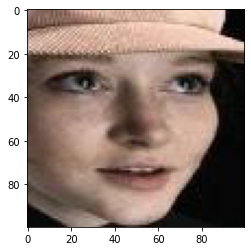

In [15]:
plt.imshow(images[51])

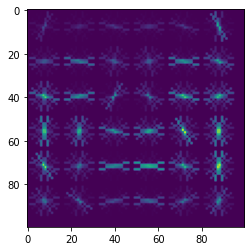

In [22]:
plt.imshow(HOG_image[51])

In [13]:
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load

## **MLP Classifier**


**A Multi-Layer Perceptron is a feedforward Artificial Neural Network (ANN). that consists of three types of layers: an input layer, hidden layer(s), and output layer.**

The Model creation and evaluation is all done in Ipython and Scikit-learn Deep learning Libraries. MLPClassifier from sklearn library has a preset of classes and parameters which could be called and set accorging to needs.


*Adapted from : Lab 07 of Computer vision Module*



**Model - 1**



In [23]:
hog_features = np.array(HOG_des)

In [40]:
classifier = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=True, random_state=1,
                    learning_rate_init=.1)

hog_features = np.array(HOG_des)
classifier.fit(hog_features, labels)

Iteration 1, loss = 1.55669635
Iteration 2, loss = 1.35215285
Iteration 3, loss = 1.24456113
Iteration 4, loss = 1.19807476
Iteration 5, loss = 1.17811734
Iteration 6, loss = 1.14942041
Iteration 7, loss = 1.14732594
Iteration 8, loss = 1.11333498
Iteration 9, loss = 1.11736232
Iteration 10, loss = 1.10145759
Iteration 11, loss = 1.08578960
Iteration 12, loss = 1.09068766
Iteration 13, loss = 1.08177990
Iteration 14, loss = 1.06973820
Iteration 15, loss = 1.06502753
Iteration 16, loss = 1.05648319
Iteration 17, loss = 1.05201570
Iteration 18, loss = 1.05188400
Iteration 19, loss = 1.03962551
Iteration 20, loss = 1.04311589
Iteration 21, loss = 1.04224784
Iteration 22, loss = 1.03108911
Iteration 23, loss = 1.04659673
Iteration 24, loss = 1.02989976
Iteration 25, loss = 1.02611425
Iteration 26, loss = 1.01861040
Iteration 27, loss = 1.02338550
Iteration 28, loss = 1.01822308
Iteration 29, loss = 1.01788189
Iteration 30, loss = 1.01478677
Iteration 31, loss = 1.01308778
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.1, max_iter=100,
              random_state=1, solver='sgd', verbose=True)

**GRID SEARCH**

**Model - 2**



In [17]:
parameters = { 'hidden_layer_sizes': [(10,), (20,), (50,), (100,)], 'activation' : ['logistic', 'relu']}

clf1 = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1, verbose=4).fit(hog_features, labels)
print(clf1.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'activation': 'logistic', 'hidden_layer_sizes': (100,)}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [25]:
mplclassifier_2 = MLPClassifier(hidden_layer_sizes=(100,), activation='logistic',) 
                    #             max_iter=100, alpha=1e-4,
                    # solver='sgd', verbose=True, random_state=1,
                    # learning_rate_init=.1)

mplclassifier_2.fit(hog_features, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(activation='logistic')

**Validation check**

Validation data is 10% of training data that was set aside before training the model

In [45]:
HOG_des_val = []
HOG_image_val = []
grey_image_val = X_val.copy()

for i in range(len(X_val)):
    # Identify keypoints and extract descriptors with SIFT
    grey_image_val[i] = color.rgb2gray(X_val[i])

for image in grey_image_val:
  des, h_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True,)
  HOG_des_val.append(des)
  HOG_image_val.append(h_image)


hog_features_val = np.array(HOG_des_val)

In [29]:
ypreds_val = mplclassifier_2.predict(hog_features_val)
print(classification_report(ypreds_val, y_val))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       1.00      0.15      0.26      1228
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0

    accuracy                           0.15      1228
   macro avg       0.14      0.02      0.04      1228
weighted avg       1.00      0.15      0.26      1228



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**MLP Model 3**



In [31]:
mplclassifier_3 = MLPClassifier(hidden_layer_sizes=(100,), activation='logistic' ,
                                max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=True, random_state=1,
                    learning_rate_init=.1)

mplclassifier_3.fit(hog_features, y_train)

Iteration 1, loss = 1.64429373
Iteration 2, loss = 1.55222338
Iteration 3, loss = 1.43401157
Iteration 4, loss = 1.36407419
Iteration 5, loss = 1.30319156
Iteration 6, loss = 1.26978614
Iteration 7, loss = 1.22546166
Iteration 8, loss = 1.20229890
Iteration 9, loss = 1.17647725
Iteration 10, loss = 1.16414529
Iteration 11, loss = 1.14823399
Iteration 12, loss = 1.14102562
Iteration 13, loss = 1.12385804
Iteration 14, loss = 1.12056190
Iteration 15, loss = 1.11526772
Iteration 16, loss = 1.10977819
Iteration 17, loss = 1.09707011
Iteration 18, loss = 1.10938333
Iteration 19, loss = 1.10046309
Iteration 20, loss = 1.09105007
Iteration 21, loss = 1.09276802
Iteration 22, loss = 1.08310373
Iteration 23, loss = 1.08543346
Iteration 24, loss = 1.08605673
Iteration 25, loss = 1.08000823
Iteration 26, loss = 1.07354989
Iteration 27, loss = 1.07594038
Iteration 28, loss = 1.06606781
Iteration 29, loss = 1.06710037
Iteration 30, loss = 1.06422541
Iteration 31, loss = 1.06203538
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(activation='logistic', learning_rate_init=0.1, max_iter=100,
              random_state=1, solver='sgd', verbose=True)

In [47]:
ypreds_val = mplclassifier_3.predict(HOG_des_val).tolist()
print(classification_report(ypreds_val, y_val))

              precision    recall  f1-score   support

           1       0.57      0.49      0.53       154
           2       0.05      0.17      0.07         6
           3       0.09      0.26      0.13        19
           4       0.86      0.72      0.79       580
           5       0.28      0.55      0.37        93
           6       0.39      0.60      0.47        45
           7       0.65      0.55      0.60       331

    accuracy                           0.62      1228
   macro avg       0.41      0.48      0.42      1228
weighted avg       0.69      0.62      0.65      1228



**Model - 4**



In [35]:
classifier_4 = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=True, random_state=1,
                    learning_rate_init=.1)

hog_features = np.array(HOG_des)
classifier_4.fit(hog_features, y_train)

Iteration 1, loss = 1.58246706
Iteration 2, loss = 1.36006823
Iteration 3, loss = 1.27305632
Iteration 4, loss = 1.23102235
Iteration 5, loss = 1.17759582
Iteration 6, loss = 1.17237797
Iteration 7, loss = 1.17138390
Iteration 8, loss = 1.13345314
Iteration 9, loss = 1.13305507
Iteration 10, loss = 1.11941004
Iteration 11, loss = 1.10422053
Iteration 12, loss = 1.09207484
Iteration 13, loss = 1.09003496
Iteration 14, loss = 1.07960002
Iteration 15, loss = 1.08901412
Iteration 16, loss = 1.06285666
Iteration 17, loss = 1.07891836
Iteration 18, loss = 1.06821249
Iteration 19, loss = 1.04977083
Iteration 20, loss = 1.04892799
Iteration 21, loss = 1.04339406
Iteration 22, loss = 1.03983498
Iteration 23, loss = 1.03175265
Iteration 24, loss = 1.04223672
Iteration 25, loss = 1.02665609
Iteration 26, loss = 1.02170454
Iteration 27, loss = 1.02080815
Iteration 28, loss = 1.01108995
Iteration 29, loss = 1.01230325
Iteration 30, loss = 1.01293546
Iteration 31, loss = 1.00449620
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.1, max_iter=100,
              random_state=1, solver='sgd', verbose=True)

In [46]:
ypreds_val = classifier_4.predict(HOG_des_val).tolist()
print(classification_report(ypreds_val, y_val))

              precision    recall  f1-score   support

           1       0.57      0.46      0.51       164
           2       0.18      0.33      0.24        12
           3       0.02      0.11      0.03         9
           4       0.70      0.85      0.77       397
           5       0.22      0.60      0.32        65
           6       0.49      0.47      0.48        73
           7       0.80      0.44      0.57       508

    accuracy                           0.58      1228
   macro avg       0.43      0.47      0.42      1228
weighted avg       0.68      0.58      0.60      1228



**Best Model**

By considering the accuracy as the defining metric the best model is `mplclassifier_3` giving 62% accuracy for validation set.

Saving this model to perform test

In [50]:
joblib.dump(mplclassifier_3, GOOGLE_DRIVE_PATH + '/Models/mlp-hog.pkl')

['drive/My Drive/ColabNotebooks/ComputerVision/Course Work/CW_Folder_PG/Models/MLPBestModel.pkl']

### Testing

In [37]:
images_test, file_names_test = import_training_data(path,'test')
print(file_names_test)

['test_0001_aligned.jpg', 'test_0002_aligned.jpg', 'test_0003_aligned.jpg', 'test_0004_aligned.jpg', 'test_0005_aligned.jpg', 'test_0006_aligned.jpg', 'test_0007_aligned.jpg', 'test_0008_aligned.jpg', 'test_0009_aligned.jpg', 'test_0010_aligned.jpg', 'test_0011_aligned.jpg', 'test_0012_aligned.jpg', 'test_0013_aligned.jpg', 'test_0014_aligned.jpg', 'test_0015_aligned.jpg', 'test_0016_aligned.jpg', 'test_0017_aligned.jpg', 'test_0018_aligned.jpg', 'test_0019_aligned.jpg', 'test_0020_aligned.jpg', 'test_0021_aligned.jpg', 'test_0022_aligned.jpg', 'test_0023_aligned.jpg', 'test_0024_aligned.jpg', 'test_0025_aligned.jpg', 'test_0026_aligned.jpg', 'test_0027_aligned.jpg', 'test_0028_aligned.jpg', 'test_0029_aligned.jpg', 'test_0030_aligned.jpg', 'test_0031_aligned.jpg', 'test_0032_aligned.jpg', 'test_0033_aligned.jpg', 'test_0034_aligned.jpg', 'test_0035_aligned.jpg', 'test_0036_aligned.jpg', 'test_0037_aligned.jpg', 'test_0038_aligned.jpg', 'test_0039_aligned.jpg', 'test_0040_aligned.jpg',

In [38]:
lables_path_test = os.path.join(path, 'labels')
file_labels_test= sorted(open(os.path.join(lables_path_test, 'list_label_test.txt'), "r").readlines())
# content_list = labels.readlines()
file_labels_test = [line.rstrip('\n') for line in file_labels_test]
print(file_labels_test)

labels_test = [label[-1] for label in file_labels_test]
print(labels_test)

['test_0001.jpg 5', 'test_0002.jpg 1', 'test_0003.jpg 4', 'test_0004.jpg 1', 'test_0005.jpg 5', 'test_0006.jpg 5', 'test_0007.jpg 3', 'test_0008.jpg 1', 'test_0009.jpg 4', 'test_0010.jpg 4', 'test_0011.jpg 3', 'test_0012.jpg 4', 'test_0013.jpg 4', 'test_0014.jpg 4', 'test_0015.jpg 1', 'test_0016.jpg 4', 'test_0017.jpg 6', 'test_0018.jpg 3', 'test_0019.jpg 4', 'test_0020.jpg 4', 'test_0021.jpg 4', 'test_0022.jpg 5', 'test_0023.jpg 1', 'test_0024.jpg 5', 'test_0025.jpg 4', 'test_0026.jpg 4', 'test_0027.jpg 6', 'test_0028.jpg 4', 'test_0029.jpg 4', 'test_0030.jpg 5', 'test_0031.jpg 5', 'test_0032.jpg 4', 'test_0033.jpg 4', 'test_0034.jpg 1', 'test_0035.jpg 1', 'test_0036.jpg 5', 'test_0037.jpg 6', 'test_0038.jpg 4', 'test_0039.jpg 5', 'test_0040.jpg 4', 'test_0041.jpg 4', 'test_0042.jpg 6', 'test_0043.jpg 1', 'test_0044.jpg 4', 'test_0045.jpg 5', 'test_0046.jpg 4', 'test_0047.jpg 4', 'test_0048.jpg 4', 'test_0049.jpg 5', 'test_0050.jpg 4', 'test_0051.jpg 4', 'test_0052.jpg 4', 'test_0053.

In [46]:
HOG_des_test = []
HOG_image_test = []
grey_image_test = images_test.copy()

for i in range(len(images_test)):
    # Identify keypoints and extract descriptors with SIFT
    grey_image_test[i] = color.rgb2gray(images_test[i])

In [49]:
for image in grey_image_test:
  des, h_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True,)
  HOG_des_test.append(des)
  HOG_image_test.append(h_image)

In [51]:
y_predict = classifier.predict(HOG_des_test).tolist()

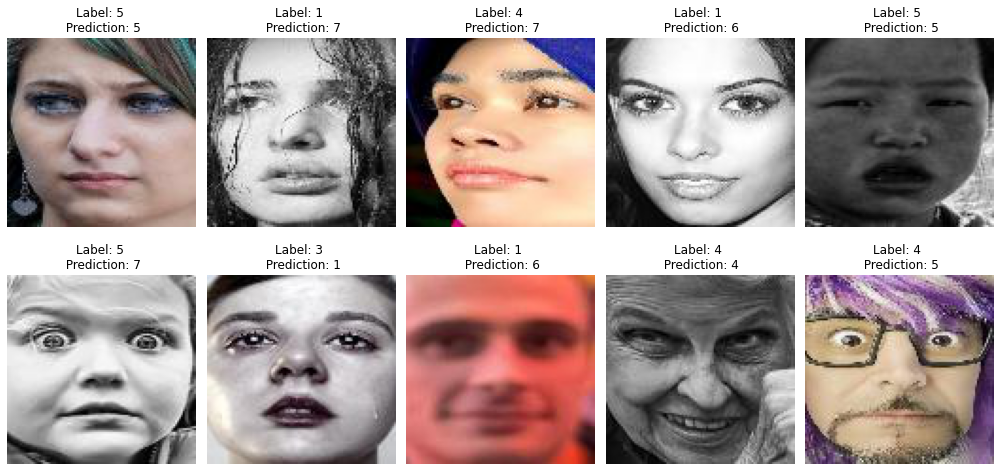

In [55]:
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(images[i])
    ax[i].set_title(f'Label: {labels_test[i]} \n Prediction: {y_predict[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [56]:
print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(labels_test, y_predict)}\n""")

Classification report for classifier MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.1, max_iter=100,
              random_state=1, solver='sgd', verbose=True):
                    precision    recall  f1-score   support

           1       0.58      0.43      0.50       329
           2       0.69      0.24      0.36        74
           3       0.21      0.08      0.12       160
           4       0.88      0.57      0.69      1185
           5       0.31      0.76      0.44       478
           6       0.46      0.46      0.46       162
           7       0.55      0.50      0.53       680

    accuracy                           0.53      3068
   macro avg       0.53      0.44      0.44      3068
weighted avg       0.62      0.53      0.54      3068




In [39]:
HOG_des_test = []
HOG_image_test = []
grey_image_test = images_test.copy()

for i in range(len(images_test)):
    # Identify keypoints and extract descriptors with SIFT
    grey_image_test[i] = color.rgb2gray(images_test[i])

In [40]:
for image in grey_image_test:
  des, h_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True,)
  HOG_des_test.append(des)
  HOG_image_test.append(h_image)

In [42]:
y_predict = classifier_4.predict(HOG_des_test).tolist()

In [44]:
print(f"""Classification report for classifier {classifier_4}:
      {metrics.classification_report(labels_test, y_predict)}\n""")

Classification report for classifier MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.1, max_iter=100,
              random_state=1, solver='sgd', verbose=True):
                    precision    recall  f1-score   support

           1       0.48      0.55      0.51       329
           2       0.54      0.27      0.36        74
           3       0.32      0.07      0.12       160
           4       0.80      0.71      0.75      1185
           5       0.63      0.17      0.26       478
           6       0.39      0.53      0.45       162
           7       0.45      0.82      0.58       680

    accuracy                           0.58      3068
   macro avg       0.52      0.45      0.43      3068
weighted avg       0.61      0.58      0.55      3068


